In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

pd.set_option('display.max_columns', None)

In [10]:
df = pd.read_csv('imputed.csv')

#cleaning
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'last_careunit',
              'admission_type']
proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']
ptParams = ['weight', 'height']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc',]
deathInfo = ['dod', 'deathtime']
ptinfo = ['hadm_id', 'subject_id']
durations = ['duration1', 'duration2', 'icu_stay_duration', 'icu_stay_days']
timeFields =  ['admittime', 'dischtime', 'intime', 'outtime', 'ext_time', 
       'int_time1', 'ext_time1', 'int_time2', 'ext_time2']

tsColumns = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]
print([i for i in df.columns if i not in categorical + proceduretype + tsColumns + ptParams + boolFields + ptinfo + deathInfo + durations + timeFields])

for i in categorical:
    df[i] = df[i].astype('category')
    
df['icu_stay_days'] = [round(i/86400) for i in df['icu_stay_duration']]
df['icu_stay_duration'] /= 3600  # now icu_stay_duration
df = df[[i for i in df.columns if i not in ("Unnamed: 0", "0")]]
df['dod'] = df['dod'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d") if not pd.isnull(x) else np.NaN)
for i in timeFields:
    df[i] = df[i].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if not pd.isnull(x) else np.NaN)
    
df = df[[i for i in df.columns if '_max' not in i and '_min' not in i]]
df = df[[i for i in df.columns if i not in ('last_careunit', 'infection_vent', 'icustay_seq', 'los')]]  # for some reason last_careunit messes up the Cox training

print(df.shape)
df.head(5)

['Unnamed: 0', 'infection_vent', 'los', 'icustay_seq']
(9474, 91)


,temp_mean,hr_mean,spo2_mean,rr_mean,sbp_mean,dbp_mean,meanbp_mean,cardiac_index_mean,pt_mean,ptt_mean,inr_mean,inr_1_mean,fibrinogen_mean,hb_mean,hematocrit_mean,wcc_mean,lymphocytes_mean,neutrophils_mean,chloride_mean,magnesium_mean,potassium_mean,creatinine_mean,free_calcium_mean,sodium_mean,bicarb_mean,bun_mean,hba1c_mean,glucose_mean,lactate_mean,po2_mean,pco2_mean,baseexcess_mean,ph_mean,insulin_mean,prbc_mean,plt_mean,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,weight,height,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,admission_location,admission_type,hospital_expire_flag,diab_un,diab_cc,icu_stay_duration,admittime,dischtime,intime,outtime,ext_time,deathtime,hadm_id,subject_id,int_time1,ext_time1,duration1,int_time2,ext_time2,duration2,dod,icu_stay_days
0,37.145834,89.393939,97.967742,24.382353,115.666667,60.515152,75.712121,2.759261,14.450000,29.8,1.200,1.200,527.0,12.0500,35.000000,13.900000,17.1,80.1,104.5,1.80,3.666667,0.80,1.1500,138.000000,25.5,12.0,6.4,124.875000,1.657143,0.500000,41.000000,0.500000,7.400000,335.333333,843.75,261.5,M,white,SINGLE,Private,ENGL,0,0,0,0,1,84.0,172.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,50.110833,2198-01-31 08:00:00,2198-02-04 12:00:00,2198-01-31 12:27:58,2198-02-02 19:06:39,2198-01-31 22:00:00,NaN,195663,27328,2198-01-31 17:00:00,2198-01-31 22:00:00,5.000000,NaT,NaT,NaN,NaT,2
1,37.023530,92.277778,97.276316,12.807692,98.000000,53.222222,67.861111,2.222764,17.350000,42.8,1.600,1.600,188.5,7.3200,22.000000,19.566667,8.3,80.1,108.0,2.10,4.375000,0.60,1.1280,142.000000,26.0,12.0,6.3,145.562500,1.400000,0.818182,42.818182,0.818182,7.398182,262.500000,375.00,122.5,F,other,DIVORCED,Self Pay,SPAN,1,0,0,0,0,60.0,170.18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,50.766667,2198-05-08 07:15:00,2198-05-15 13:49:00,2198-05-08 13:14:00,2198-05-10 19:46:00,2198-05-09 09:29:00,NaN,106984,6280,2198-05-08 17:00:00,2198-05-09 09:29:00,16.483333,NaT,NaT,NaN,NaT,2
2,36.883784,85.027027,99.636364,15.342105,121.000000,58.459459,80.108108,2.108540,17.633333,59.3,1.600,1.600,138.0,10.0600,28.000000,21.850000,12.2,84.8,111.0,2.60,4.285714,1.20,1.1560,140.333333,26.5,19.0,9.9,120.629630,1.400000,1.166667,41.333333,1.166667,7.404286,170.000000,375.00,144.5,F,asian,MARRIED,Medicare,CANT,1,0,0,0,1,57.0,165.10,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,0,0,48.630000,2189-02-18 08:00:00,2189-03-17 14:20:00,2189-02-18 10:51:08,2189-02-20 13:37:48,2189-02-19 09:00:00,NaN,123613,15201,2189-02-18 13:00:00,2189-02-19 09:00:00,20.000000,NaT,NaT,NaN,2191-12-14,2
3,37.532258,87.939394,97.531250,16.212121,113.191176,56.823529,73.575758,2.899448,13.800000,28.3,1.200,1.200,230.0,13.8000,40.166667,14.000000,8.1,88.0,106.0,1.85,3.800000,0.55,1.1250,139.000000,27.5,12.5,5.6,126.533333,1.785714,0.625000,45.750000,0.625000,7.377778,229.666667,1184.00,161.0,M,other,MARRIED,Private,PTUN,0,0,0,0,1,135.0,190.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,1,0,23.550556,2118-01-25 07:15:00,2118-01-29 13:00:00,2118-01-25 10:46:42,2118-01-26 12:33:02,2118-01-25 17:30:00,NaN,126027,25226,2118-01-25 13:00:00,2118-01-25 17:30:00,4.500000,NaT,NaT,NaN,NaT,1
4,36.880362,87.240000,99.083333,13.397959,113.440000,63.810000,79.446667,2.386696,13.200000,30.5,1.175,1.175,377.0,9.8125,30.000000,11.600000,15.0,61.0,108.0,3.60,4.420000,1.20,1.0275,137.000000,23.0,16.0,6.4,134.230769,1.500000,-3.000000,44.600000,-3.000000,7.318000,162.666667,187.50,95.0,M,white,MARRIED,Medicare,HIND,1,0,0,0,0,70.0,175.26,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,1,0,47.000000,2198-01-01 07:15:00,2198-01-09 13:07:00,2198-01-01 10:47:00,2198-01-03 12:00:00,2198-01-01 21:00:00,NaN,190332,19637,2198-01-01 13:00:00,2198-01-01 21:00:00,8.000000,NaT,NaT,NaN

In [11]:
# target variable: icu stay duration
data_y = np.array([(True, df['icu_stay_duration'][i]) for i in range(df.shape[0])], dtype=[('Status', '?'), ('Stay_in_hrs', '<f8')])
print(data_y)

# one hot encodes categorical variables and removes columns related to irrelevant stuff
data_x = df[[i for i in df.columns if i not in durations + ptinfo + deathInfo + timeFields]]
print(data_x.columns)

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.shape

[( True,  50.11083333) ( True,  50.76666667) ( True,  48.63      ) ...
 ( True,  25.16416667) ( True, 142.52277778) ( True,  22.29111111)]
Index(['temp_mean', 'hr_mean', 'spo2_mean', 'rr_mean', 'sbp_mean', 'dbp_mean',
       'meanbp_mean', 'cardiac_index_mean', 'pt_mean', 'ptt_mean', 'inr_mean',
       'inr_1_mean', 'fibrinogen_mean', 'hb_mean', 'hematocrit_mean',
       'wcc_mean', 'lymphocytes_mean', 'neutrophils_mean', 'chloride_mean',
       'magnesium_mean', 'potassium_mean', 'creatinine_mean',
       'free_calcium_mean', 'sodium_mean', 'bicarb_mean', 'bun_mean',
       'hba1c_mean', 'glucose_mean', 'lactate_mean', 'po2_mean', 'pco2_mean',
       'baseexcess_mean', 'ph_mean', 'insulin_mean', 'prbc_mean', 'plt_mean',
       'gender', 'ethnicity', 'marital_status', 'insurance', 'language',
       'aortic', 'mit', 'tricuspid', 'pulmonary', 'cabg', 'weight', 'height',
       'reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids',
       'ckd', 'copd', 'arrhythmia', 'pud'

(9474, 132)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_x_numeric, data_y, test_size=0.25, random_state=0)

In [13]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.695


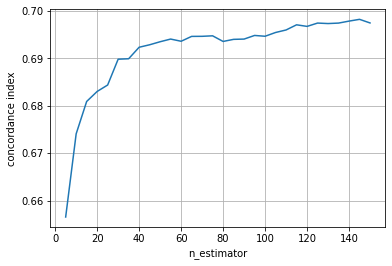

In [14]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [15]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=150, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.689
